# Introduction

I spend quite a bit of time on [Reddit](https://reddit.com) browsing my personalized list of online forums and all the social news the algorithms have aggregated for me. As with any type of social media, people must be very diligent in protecting themselves from misinformation to avoid being manipulated. Thus, it is important to understand the source of the information you are receiving and if it was curated in any way.

Moderators play a large role in balancing the Reddit ecosystem by banning internet trolls and removing offensive content. They are the gatekeepers to the information you can find on Reddit. But with great power comes great responsibility. Recently, there was a [post](https://www.reddit.com/r/therewasanattempt/comments/gk0w4c/to_have_independently_moderated_subreddits/) in the subreddit [/r/therewasanattempt](https://www.reddit.com/r/therewasanattempt/) on how user [/u/rootin-tootin_putin](https://reddit.com/u/rootin-tootin_putin) was banned from 40+ major subreddits in about 40 minutes when he allegedly discovered that the just 5 users control nearly 100 of the top 500 subreddits. If true, it would be extremely disturbing that a tiny group of users can effectively influence the narrative I see on Reddit.

I was curious to see if this claim was true. Using the Reddit API, I went to work.

# Import Libraries

In [1]:
# packages for parsing and data manipulation
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from itertools import combinations

# reddit API wrapper
import praw

# plotting
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
register_matplotlib_converters()

# Read in Credentials for Reddit API

In [2]:
# read credentials for Reddit API, stored on local text file
with open("credentials.txt","r") as credentials_file:
    credentials = credentials_file.readlines()
    _client_id = credentials[0].strip()
    _client_secret = credentials[1].strip()
    _username = credentials[2].strip()
    _password = credentials[3].strip()
    _user_agent = credentials[4].strip()
credentials_file.close()

In [3]:
# reddit instance from praw
reddit = praw.Reddit(client_id=_client_id,
                     client_secret=_client_secret,
                     username=_username,
                     password=_password,
                     user_agent=_user_agent)

# delete credentials variables
del _client_id, _client_secret, _username, _password, _user_agent

# Extract and Manipulate Data

Using the Reddit API, I extracted the list of moderators for the most popular subreddits.

In [4]:
# number of subreddits to analyze
number_popular_subreddits = 500

# find info on top subreddits
top_subs_df = pd.DataFrame()
top_subs_df["subreddit"] = [subreddit.display_name for subreddit in reddit.subreddits.popular(limit=number_popular_subreddits+1) if subreddit.display_name != "Home"]
top_subs_df["moderators"] = top_subs_df.subreddit.map(lambda sub: [moderator.name for moderator in reddit.subreddit(sub).moderator()])

top_subs_df

subreddit                                         moderators
0              AskReddit  [krispykrackers, flyryan, Ooer, roastedbagel, ...
1         AnimalCrossing  [devvydowner, Callisto_Io, birdwithbrow, SaneI...
2              gtaonline  [Psychko, AutoModerator, OcelotWolf, Paralyzed...
3        leagueoflegends  [hoosakiwi, sarahbotts, IcyColdStare, Sepik121...
4                  funny  [Kylde, DuckDragon, Kensin, funny_mod, MrAwkwa...
..                   ...                                                ...
495               Advice  [Sephr, dzneill, micronerd01, roastedlasagna, ...
496   AskRedditAfterDark  [AerateMark, GodOfAtheism, eightNote, stopspam...
497              Cuckold                    [MyParadiseCircus, cuckold-bot]
498           MagicArena  [Tharob, Shardot, OriginMD, AutoModerator, pig...
499  justneckbeardthings  [Expir, courain, BipolarBear0, ErrorlessGnome,...

[500 rows x 2 columns]

TF-IDF, short for term frequency–inverse document frequency, turns all the words in a body of text into a vector. `TfidfVectorizer` from the `scikit-learn` package provides us a matrix of TF-IDF features. Using this function, I can easily create a matrix to see if a redditor is a moderator for a subreddit.

In [5]:
# reformat moderators column
top_subs_df["moderators_str"] = top_subs_df.moderators.map(lambda mods: " ".join(mods))

# tfidf instance. token pattern to accept hyphens
vectorizer = TfidfVectorizer(token_pattern=r"(?u)\S\S+")
X = vectorizer.fit_transform(top_subs_df["moderators_str"])

# create dataframe from tfidf, > 0 means user is moderator for subreddit
mods_df = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names()) > 0

# append tfidf dataframe to original dataframe
mods_subs_df = pd.concat([top_subs_df, mods_df*1], axis=1, sort=True)

# drop original moderators info as it is present already
mods_subs_df.drop(["moderators", "moderators_str"], axis=1, inplace=True)

From this table, I can calculate the number of subreddits each user moderates

In [6]:
# set subreddit column as index
mods_subs_df.set_index("subreddit", inplace=True)

# transpose
mods_subs_df = mods_subs_df.T

# number of popular subreddits that redditors are moderators for
mods_subs_df["num_subreddits"] = mods_subs_df.sum(axis=1)

mods_subs_df

subreddit           AskReddit  AnimalCrossing  gtaonline  leagueoflegends  \
--cheese--                  0               0          0                0   
-343-guilty-spark-          0               0          0                0   
-archivist                  0               0          0                0   
-cultrix-                   0               0          0                0   
-d___b-                     0               0          0                0   
...                       ...             ...        ...              ...   
zurfer75                    0               0          0                0   
zwart27                     0               0          0                0   
zwemvest                    0               0          0                0   
zylda                       0               0          0                0   
zylvian                     0               0          0                0   

subreddit           funny  Minecraft  PublicFreakout  todayilearned  politics  \
--cheese--              0          0               0              0         0   
-343-guilty-spark-      0          0               0              0         0   
-archivist              0          0               0              0         0   
-cultrix-               0          0               0              0         0   
-d___b-                 0          0               0              0         0   
...                   ...        ...             ...            ...       ...   
zurfer75                0          0               0              0         0   
zwart27                 0          0               0              0         0   
zwemvest                0          0               0              0         0   
zylda                   0          0               0              0         0   
zylvian                 0          0               0              0         0   

subreddit           gaming  ...  farmingsimulator  webdev  androidapps  \
--cheese--               0  ...                 0       0            0   
-343-guilty-spark-       0  ...                 0       0            0   
-archivist               0  ...                 0       0            0   
-cultrix-                0  ...                 0       0            0   
-d___b-                  0  ...                 0       0            0   
...                    ...  ...               ...     ...          ...   
zurfer75                 0  ...                 0       0            0   
zwart27                  0  ...                 0       0            0   
zwemvest                 0  ...                 0       0            0   
zylda                    0  ...                 0       0            0   
zylvian                  0  ...                 0       0            0   

subreddit           woodworking  Advice  AskRedditAfterDark  Cuckold  \
--cheese--                    0       0                   0        0   
-343-guilty-spark-            0       0                   0        0   
-archivist                    0       0                   0        0   
-cultrix-                     0       0                   0        0   
-d___b-                       0       0                   0        0   
...                         ...     ...                 ...      ...   
zurfer75                      0       0                   0        0   
zwart27                       0       0                   0        0   
zwemvest                      0       0                   0        0   
zylda                         0       0                   0        0   
zylvian                       0       0                   0        0   

subreddit           MagicArena  justneckbeardthings  num_subreddits  
--cheese--                   0                    0               1  
-343-guilty-spark-           0                    0               1  
-archivist                   0                    0               1  
-cultrix-                    0                    0               1 

Using the Reddit API, I calculated the number of subscribers per subreddit, and derived the number of subscribers a moderator can moderate.

In [7]:
# copy
mods_subscribers_df = mods_subs_df.copy().drop("num_subreddits", axis=1)

# find number of subscribers per subreddit
for sub in mods_subscribers_df.columns:
    mods_subscribers_df[sub] = mods_subscribers_df[sub]*reddit.subreddit(sub).subscribers

# sum up subscribers per moderator
mods_subscribers_df["num_subscribers"] = mods_subscribers_df.sum(axis=1)

mods_subscribers_df

subreddit           AskReddit  AnimalCrossing  gtaonline  leagueoflegends  \
--cheese--                  0               0          0                0   
-343-guilty-spark-          0               0          0                0   
-archivist                  0               0          0                0   
-cultrix-                   0               0          0                0   
-d___b-                     0               0          0                0   
...                       ...             ...        ...              ...   
zurfer75                    0               0          0                0   
zwart27                     0               0          0                0   
zwemvest                    0               0          0                0   
zylda                       0               0          0                0   
zylvian                     0               0          0                0   

subreddit           funny  Minecraft  PublicFreakout  todayilearned  politics  \
--cheese--              0          0               0              0         0   
-343-guilty-spark-      0          0               0              0         0   
-archivist              0          0               0              0         0   
-cultrix-               0          0               0              0         0   
-d___b-                 0          0               0              0         0   
...                   ...        ...             ...            ...       ...   
zurfer75                0          0               0              0         0   
zwart27                 0          0               0              0         0   
zwemvest                0          0               0              0         0   
zylda                   0          0               0              0         0   
zylvian                 0          0               0              0         0   

subreddit           gaming  ...  farmingsimulator  webdev  androidapps  \
--cheese--               0  ...                 0       0            0   
-343-guilty-spark-       0  ...                 0       0            0   
-archivist               0  ...                 0       0            0   
-cultrix-                0  ...                 0       0            0   
-d___b-                  0  ...                 0       0            0   
...                    ...  ...               ...     ...          ...   
zurfer75                 0  ...                 0       0            0   
zwart27                  0  ...                 0       0            0   
zwemvest                 0  ...                 0       0            0   
zylda                    0  ...                 0       0            0   
zylvian                  0  ...                 0       0            0   

subreddit           woodworking  Advice  AskRedditAfterDark  Cuckold  \
--cheese--                    0       0                   0        0   
-343-guilty-spark-            0       0                   0        0   
-archivist                    0       0                   0        0   
-cultrix-                     0       0                   0        0   
-d___b-                       0       0                   0        0   
...                         ...     ...                 ...      ...   
zurfer75                      0       0                   0        0   
zwart27                       0       0                   0        0   
zwemvest                      0       0                   0        0   
zylda                         0       0                   0        0   
zylvian                       0       0                   0        0   

subreddit           MagicArena  justneckbeardthings  num_subscribers  
--cheese--                   0                    0          8592266  
-343-guilty-spark-           0                    0           439393  
-archivist                   0                    0           239266  
-cultrix-                    0                    0           42

# Visualizations

First, we'll plot a histogram to see the spread of how many popular subreddits a typical moderator moderates.

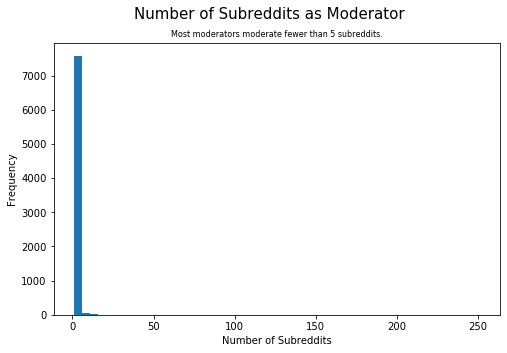

In [8]:
# set figure size
fig, ax = plt.subplots(figsize=(8,5))

# histogram
plt.hist(mods_subs_df.num_subreddits, bins=range(min(mods_subs_df.num_subreddits), max(mods_subs_df.num_subreddits) + 5, 5))

# x,y labels
ax.set_xlabel("Number of Subreddits")
ax.set_ylabel("Frequency")

# title and subtitle
plt.suptitle("Number of Subreddits as Moderator", fontsize=15)
plt.title("Most moderators moderate fewer than 5 subreddits.", fontsize=8)

# save figure
plt.savefig('mods_subreddit_hist.png')

# show
plt.show()

Next, let's check who moderates the highest number of popular subreddits.

In [9]:
# sort values by number of subreddits moderated
mods_subs_plt = mods_subs_df.copy()

# choose top 50 users
mods_subs_plt = mods_subs_plt.nlargest(50,'num_subreddits')

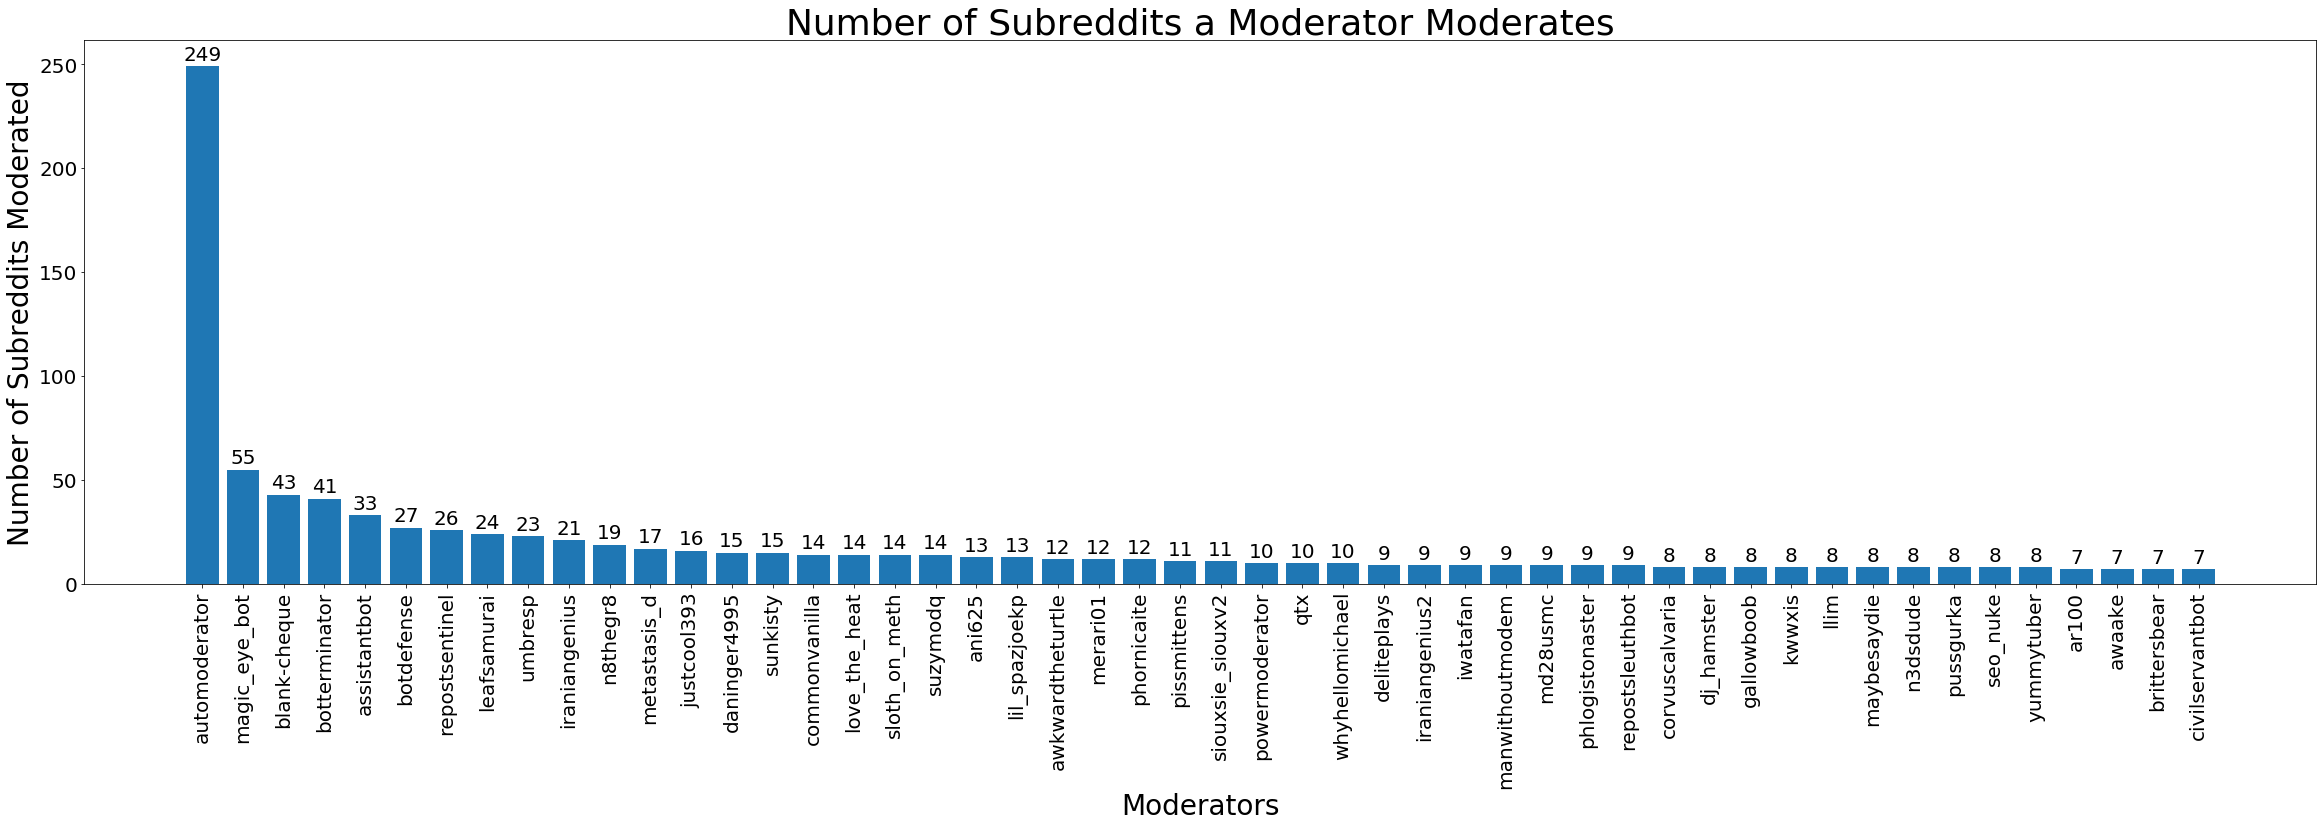

In [10]:
# set figure size
fig, ax = plt.subplots(figsize=(40,10))

# set x and y
x = mods_subs_plt.index
y = mods_subs_plt.num_subreddits

# bar chart
plt.bar(x, y)

# label value on top of bar
for i, v in enumerate(y):
    ax.text(i, v+3, str(v), color='black', horizontalalignment='center', fontsize=20)
    
# x,y labels
ax.set_xlabel("Moderators", fontsize=28)
ax.set_ylabel("Number of Subreddits Moderated", fontsize=28)
    
# rotate xticks
plt.xticks(rotation=90)

# tick size larger
ax.tick_params(axis='both', which='major', labelsize=20)

# title
plt.title("Number of Subreddits a Moderator Moderates", fontsize=36)

# save figure
plt.savefig('mods_subreddit_count.png')

# show
plt.show()

We can also see how subscribers are under a moderator's control in these popular subreddits. Subscribers can show up in several subreddits, so this graph may be a bit misleading.

In [11]:
# sort values by number of subreddits moderated
mods_subscribers_plt = mods_subscribers_df.copy()

# choose top 50 users
mods_subscribers_plt = mods_subscribers_plt.nlargest(50,"num_subscribers").sort_values(by="num_subscribers")

# divide subscribers by 1 million
mods_subscribers_plt["num_subscribers"] = round(mods_subscribers_plt["num_subscribers"]/1e6, 2)

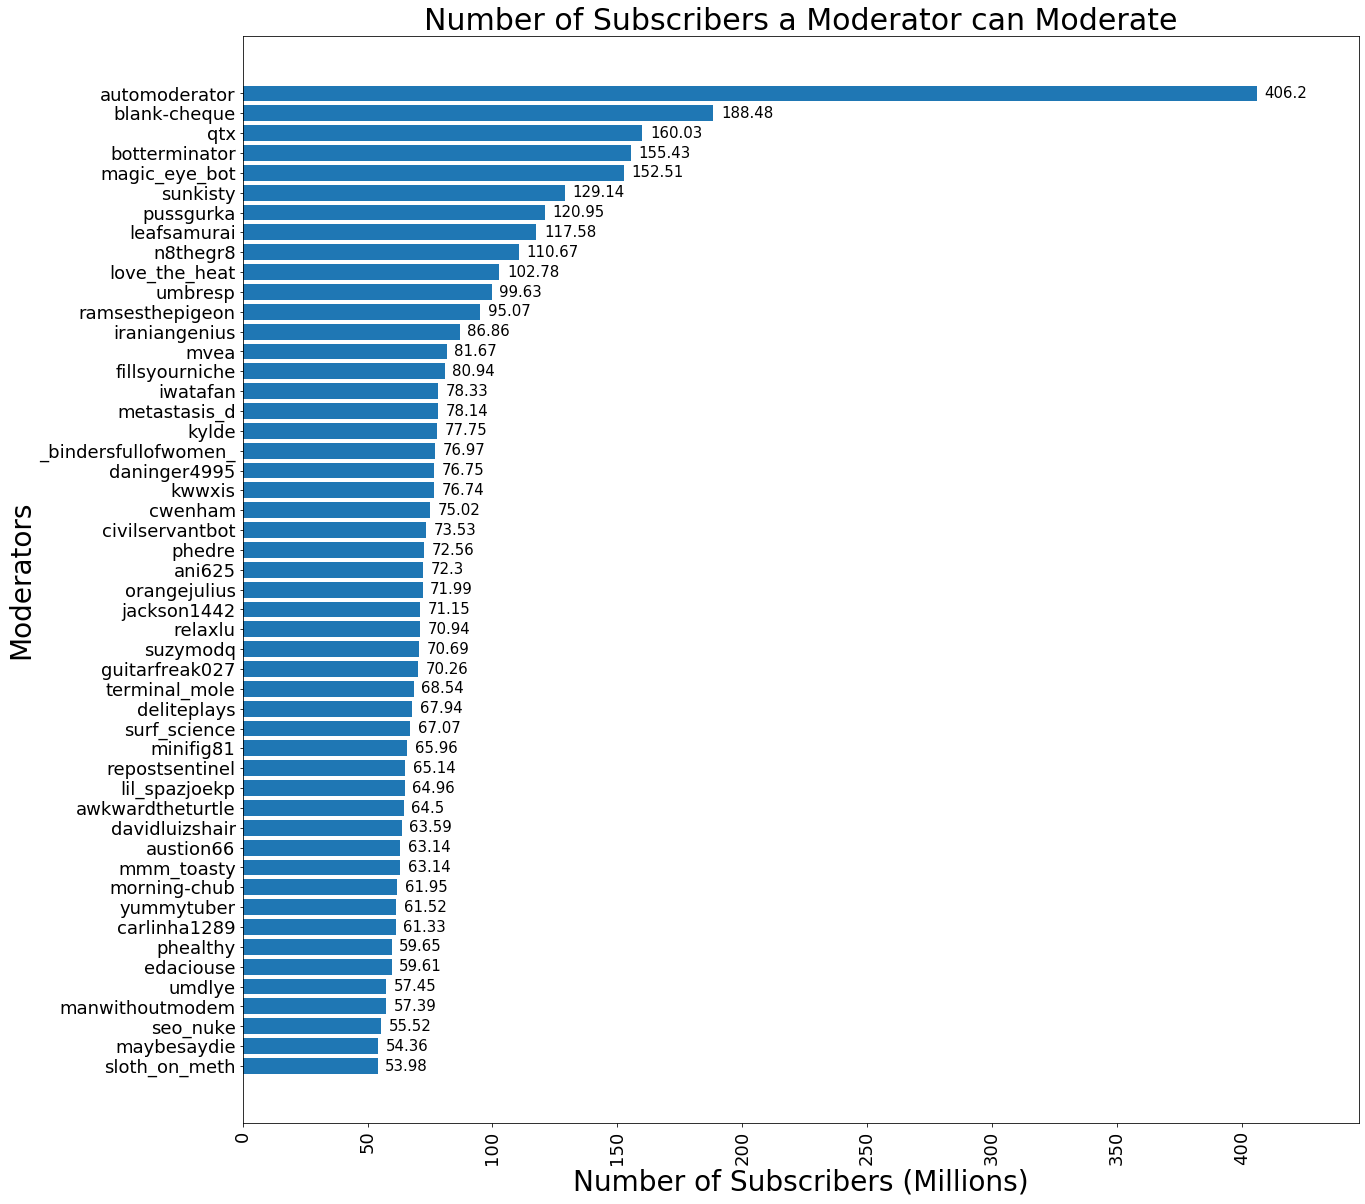

In [12]:
# set figure size
fig, ax = plt.subplots(figsize=(20,20))

# set x and y
x = mods_subscribers_plt.index
y = mods_subscribers_plt.num_subscribers

# bar chart
ax.barh(x, y)

# label value on top of bar
for i, v in enumerate(y):
    ax.text(v + 3, i, str(v), color='black', verticalalignment='center', fontsize=15)
    
# x,y labels
ax.set_xlabel("Number of Subscribers (Millions)", fontsize=28)
ax.set_ylabel("Moderators", fontsize=28)

# rotate xticks
plt.xticks(rotation=90)

# tick size larger
ax.tick_params(axis='both', which='major', labelsize=18)

# title
plt.title("Number of Subscribers a Moderator can Moderate", fontsize=30)

# x limit
plt.xlim(0, max(y)*1.1)

# save figure
plt.savefig('mods_subscribers.png')

# show
plt.show()

Next, we'll display a heatmap to see who is a moderator of which subreddit 

In [13]:
# select users who moderate 5 or more subreddits
mods_subs_plt = mods_subs_df[mods_subs_df.num_subreddits >= 5].copy()

# sort rows by most subreddits
mods_subs_plt.sort_values(by="num_subreddits", ascending=False, inplace=True)

# drop num_subreddits
mods_subs_plt.drop(["num_subreddits"], axis=1, inplace=True)

In [14]:
# set figure size
fig, ax = plt.subplots(figsize=(mods_subs_plt.shape[1], mods_subs_plt.shape[0]))

# heatmap, with no colorbar
sns.heatmap(mods_subs_plt, linewidths=0.1, linecolor="lightgrey", cmap="Blues", cbar=False)

# x,y labels
ax.set_xlabel("Subreddits", fontsize=200)
ax.set_ylabel("Moderators", fontsize=200)

# put xticks on top
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top") 

# rotate xticks
plt.xticks(rotation=90)

# tick size larger
ax.tick_params(axis='both', which='major', labelsize=40)

# add lines
ax.hlines(list(range(10, mods_subs_plt.shape[0], 10)), *ax.get_xlim())
ax.vlines(list(range(10, mods_subs_plt.shape[1], 10)), *ax.get_ylim())

# title
plt.title("Who Is Your Moderator?", fontsize=350, pad=200)

# save figure
plt.savefig('mods_subreddit_heatmap.png')

# show
plt.show()

Let's also verify if [/u/rootin-tootin_putin](https://reddit.com/u/rootin-tootin_putin)'s claim that just 5 users control nearly 100 of the top 500 subreddits is true.

In [16]:
# dataframe to store results
combos = pd.DataFrame(columns=["mod1", "mod2", "mod3", "mod4", "mod5", "sum_subreddits"])

# select mods with at least 10 subreddits for faster iteration
mods_subs_plt = mods_subs_df[mods_subs_df.num_subreddits >= 10].copy()

# drop rows with bots
potential_bots = ["automoderator", "magic_eye_bot", "botterminator", "assistantbot", "botdefense", "repostsentinel", "powermoderator"]
mods_subs_plt.drop(potential_bots, inplace=True)

# get each combination of mods
for combo in combinations(mods_subs_plt.index, 5):
    mods_list = list(combo)
    
    # calculate sum
    sum_subreddits = sum(mods_subs_plt.loc[mods_list].sum() > 0)

    # append to dataframe
    df = pd.DataFrame([mods_list + [sum_subreddits]], columns=["mod1", "mod2", "mod3", "mod4", "mod5", "sum_subreddits"])
    combos = pd.concat([combos, df])

# find combination with highest number of subreddits
max_subreddits = max(combos.sum_subreddits)
combos_max = combos[combos.sum_subreddits == max_subreddits]

# print results
print("{0} combinations of moderators together moderate {1} subreddits:".format(combos_max.shape[0],max_subreddits))
for idx, row in combos_max.iterrows():
    print(", ".join([row.mod1, row.mod2, row.mod3, row.mod4, row.mod5]) )

1 combinations of moderators together moderate 92 subreddits:
blank-cheque, iraniangenius, love_the_heat, n8thegr8, umbresp


# Conclusion

As it turns out, [/u/rootin-tootin_putin](https://reddit.com/u/rootin-tootin_putin)'s claim seems to be substantiated. It does really only take 5 moderators to be able to moderate nearly 20% of the 500 most popular subreddits. Considering that a single individual can own several different accounts, having such a few number of users be able to control such a large number of popular subreddits can be dangerous. Especially as 2020 is an election year, we may begin to see increased activity around misinformation and allow powerful moderators to shift the narrative across Reddit for their own agenda. While no social media is devoid of misinformation, we must all take extra care in realizing where we receive information, how we receive information, and who we receive information from.